# 4章 顧客の全体像を把握する１０本ノック

引き続き、スポーツジムの会員データを使って顧客の行動を分析していきます。  
３章で顧客の全体像を把握しました。  
ここからは、機械学習を用いて顧客のグループ化や顧客の利用予測行なっていきましょう。  
ここでは、教師なし学習、教師あり学習の回帰を取り扱います。

### ノック31：データを読み込んで確認しよう

In [1]:
import pandas as pd
uselog = pd.read_csv('use_log.csv')
uselog.isnull().sum()

log_id         0
customer_id    0
usedate        0
dtype: int64

In [2]:
customer = pd.read_csv('customer_join.csv')
customer.isnull().sum()

customer_id             0
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
dtype: int64

### ノック32：クラスタリングで顧客をグループ化しよう

In [3]:
customer_clustering = customer[['mean', 'median', 'max', 'min', 'membership_period']]
customer_clustering.head()

,mean,median,max,min,membership_period
0,4.833333,5.0,8,2,47
1,5.083333,5.0,7,3,47
2,4.583333,5.0,6,3,47
3,4.833333,4.5,7,2,47
4,3.916667,4.0,6,1,47


In [4]:
# k-meansでクラスタリングする。membership_periodが大きいので、標準化が必要
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
#標準化
customer_clustering_sc = sc.fit_transform(customer_clustering)
# モデルの定義
kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit(customer_clustering_sc)
#customer_clustering['cluster'] = clusters.labels_
customer_clustering.loc[:,('cluster')] = clusters.labels_
print(customer_clustering['cluster'].unique())
customer_clustering.head()

[3 1 0 2]


/Users/saturn/.pyenv/versions/3.8.2/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/saturn/.pyenv/versions/3.8.2/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,mean,median,max,min,membership_period,cluster
0,4.833333,5.0,8,2,47,3
1,5.083333,5.0,7,3,47,3
2,4.583333,5.0,6,3,47,3
3,4.833333,4.5,7,2,47,3
4,3.916667,4.0,6,1,47,3


### ノック33：クラスタリング結果を分析しよう

In [5]:
customer_clustering.columns=['月内平均値','月内中央値','月内最大値', '月内最小値', '会員期間', 'cluster']
customer_clustering.groupby('cluster').count()

,月内平均値,月内中央値,月内最大値,月内最小値,会員期間
cluster,,,,,
0,1336,1336,1336,1336,1336
1,761,761,761,761,761
2,846,846,846,846,846
3,1249,1249,1249,1249,1249


In [6]:
customer_clustering.groupby('cluster').mean()

,月内平均値,月内中央値,月内最大値,月内最小値,会員期間
cluster,,,,,
0,5.522518,5.373129,8.743263,2.686377,14.831587
1,3.051243,2.885677,4.750329,1.653088,9.269382
2,8.054608,8.039598,10.009456,6.160757,7.072104
3,4.677494,4.671337,7.232986,2.153723,36.915933


### ノック34：クラスタリング結果を可視化してみよう

In [7]:
# 主成分分析を使い次元削除をする
from sklearn.decomposition import PCA
X = customer_clustering_sc
pca = PCA(n_components=2)
pca.fit(X)
x_pca = pca.transform(X)
pca_df = pd.DataFrame(x_pca)
pca_df['cluster'] = customer_clustering['cluster']

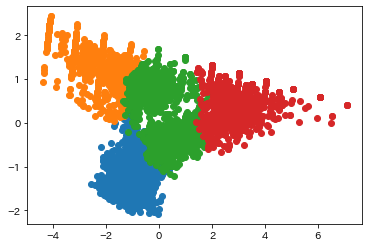

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

for i in customer_clustering['cluster'].unique():
    tmp = pca_df.loc[pca_df['cluster'] == i]
    plt.scatter(tmp[0], tmp[1])

### ノック35：クラスタリング結果をもとに退会顧客の傾向を把握しよう

In [9]:
# 退会・継続ユーザがどのくらいいるか
customer_clustering = pd.concat([customer_clustering, customer], axis=1)
customer_clustering.groupby(['cluster', 'is_deleted'], as_index=False).count()[['cluster', 'is_deleted', 'customer_id']]

,cluster,is_deleted,customer_id
0,0,0,785
1,0,1,551
2,1,1,761
3,2,0,827
4,2,1,19
5,3,0,1230
6,3,1,19


In [10]:
# 定期利用しているか確認する
customer_clustering.groupby(['cluster', 'routine_flg'], as_index=False).count()[['cluster', 'routine_flg', 'customer_id']]

,cluster,routine_flg,customer_id
0,0,0,229
1,0,1,1107
2,1,0,496
3,1,1,265
4,2,0,52
5,2,1,794
6,3,0,2
7,3,1,1247


結論：
- 0: 退会・継続バランスが良い / 定期的に利用している人の方が多い
- 1: すぐ退会した / 定期利用していない人が多い
- 2: 定期利用者が多い。ただ３ほどではない
- 3: 定期利用者が多い常連

### ノック36：翌月の利用回数予測を行うためのデータ準備をしよう

In [11]:
uselog['usedate'] = pd.to_datetime(uselog['usedate'])
uselog['年月'] = uselog['usedate'].dt.strftime('%Y%m')
uselog_months = uselog.groupby(['年月', 'customer_id'],as_index=False).count()
uselog_months.rename(columns={'log_id':'count'}, inplace=True)
uselog_months.head()

,年月,customer_id,count,usedate
0,201804,AS002855,4,4
1,201804,AS009013,2,2
2,201804,AS009373,3,3
3,201804,AS015315,6,6
4,201804,AS015739,7,7


In [12]:
year_months = list(uselog_months["年月"].unique())
predict_data = pd.DataFrame()
for i in range(6, len(year_months)):
    tmp = uselog_months.loc[uselog_months["年月"]==year_months[i]]
    tmp.rename(columns={"count":"count_pred"}, inplace=True)
    for j in range(1, 7):
        tmp_before = uselog_months.loc[uselog_months["年月"]==year_months[i-j]]
        del tmp_before["年月"]
        tmp_before.rename(columns={"count":"count_{}".format(j-1)}, inplace=True)
        tmp = pd.merge(tmp, tmp_before, on="customer_id", how="left")
    predict_data = pd.concat([predict_data, tmp], ignore_index=True)
predict_data.head()

/Users/saturn/.pyenv/versions/3.8.2/lib/python3.8/site-packages/pandas/core/frame.py:4290: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,年月,customer_id,count_pred,usedate_x,count_0,usedate_y,count_1,usedate_x,count_2,usedate_y,count_3,usedate_x,count_4,usedate_y,count_5,usedate
0,201810,AS002855,3,3,7.0,7.0,3.0,3.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0
1,201810,AS008805,2,2,2.0,2.0,5.0,5.0,7.0,7.0,8.0,8.0,NaN,NaN,NaN,NaN
2,201810,AS009373,5,5,6.0,6.0,6.0,6.0,7.0,7.0,4.0,4.0,4.0,4.0,3.0,3.0
3,201810,AS015233,7,7,9.0,9.0,11.0,11.0,5.0,5.0,7.0,7.0,7.0,7.0,NaN,NaN
4,201810,AS015315,4,4,7.0,7.0,3.0,3.0,6.0,6.0,3.0,3.0,3.0,3.0,6.0,6.0


In [13]:
predict_data = predict_data.dropna()
predict_data = predict_data.reset_index(drop=True)
predict_data.head()

,年月,customer_id,count_pred,usedate_x,count_0,usedate_y,count_1,usedate_x,count_2,usedate_y,count_3,usedate_x,count_4,usedate_y,count_5,usedate
0,201810,AS002855,3,3,7.0,7.0,3.0,3.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0
1,201810,AS009373,5,5,6.0,6.0,6.0,6.0,7.0,7.0,4.0,4.0,4.0,4.0,3.0,3.0
2,201810,AS015315,4,4,7.0,7.0,3.0,3.0,6.0,6.0,3.0,3.0,3.0,3.0,6.0,6.0
3,201810,AS015739,5,5,6.0,6.0,5.0,5.0,8.0,8.0,6.0,6.0,5.0,5.0,7.0,7.0
4,201810,AS019860,7,7,5.0,5.0,7.0,7.0,4.0,4.0,6.0,6.0,8.0,8.0,6.0,6.0


### ノック37：特徴となる変数を付与しよう

In [14]:
predict_data = pd.merge(predict_data, customer[['customer_id', 'start_date']], on='customer_id', how='left')
predict_data.head()

,年月,customer_id,count_pred,usedate_x,count_0,usedate_y,count_1,usedate_x,count_2,usedate_y,count_3,usedate_x,count_4,usedate_y,count_5,usedate,start_date
0,201810,AS002855,3,3,7.0,7.0,3.0,3.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,2016-11-01
1,201810,AS009373,5,5,6.0,6.0,6.0,6.0,7.0,7.0,4.0,4.0,4.0,4.0,3.0,3.0,2015-11-01
2,201810,AS015315,4,4,7.0,7.0,3.0,3.0,6.0,6.0,3.0,3.0,3.0,3.0,6.0,6.0,2015-07-01
3,201810,AS015739,5,5,6.0,6.0,5.0,5.0,8.0,8.0,6.0,6.0,5.0,5.0,7.0,7.0,2017-06-01
4,201810,AS019860,7,7,5.0,5.0,7.0,7.0,4.0,4.0,6.0,6.0,8.0,8.0,6.0,6.0,2017-10-01


In [15]:
# 会員期間を月単位で作成
predict_data["now_date"] = pd.to_datetime(predict_data["年月"], format="%Y%m")
predict_data["start_date"] = pd.to_datetime(predict_data["start_date"])
from dateutil.relativedelta import relativedelta
predict_data["period"] = None

for i in range(len(predict_data)):
    delta = relativedelta(predict_data["now_date"][i], predict_data["start_date"][i])
    #predict_data["period"][i] = delta.years*12 + delta.months
    predict_data.loc[i,('period')] = delta.years*12 + delta.months

predict_data.head()

,年月,customer_id,count_pred,usedate_x,count_0,usedate_y,count_1,usedate_x,count_2,usedate_y,count_3,usedate_x,count_4,usedate_y,count_5,usedate,start_date,now_date,period
0,201810,AS002855,3,3,7.0,7.0,3.0,3.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,2016-11-01,2018-10-01,23
1,201810,AS009373,5,5,6.0,6.0,6.0,6.0,7.0,7.0,4.0,4.0,4.0,4.0,3.0,3.0,2015-11-01,2018-10-01,35
2,201810,AS015315,4,4,7.0,7.0,3.0,3.0,6.0,6.0,3.0,3.0,3.0,3.0,6.0,6.0,2015-07-01,2018-10-01,39
3,201810,AS015739,5,5,6.0,6.0,5.0,5.0,8.0,8.0,6.0,6.0,5.0,5.0,7.0,7.0,2017-06-01,2018-10-01,16
4,201810,AS019860,7,7,5.0,5.0,7.0,7.0,4.0,4.0,6.0,6.0,8.0,8.0,6.0,6.0,2017-10-01,2018-10-01,12


### ノック38：来月の利用回数予測モデルを作成しよう

In [16]:
pred = predict_data.loc[predict_data["start_date"]>=pd.to_datetime("20180401")]
from sklearn import linear_model
import sklearn.model_selection
model = linear_model.LinearRegression()
X = pred[["count_0","count_1","count_2","count_3","count_4","count_5","period"]]
y = pred["count_pred"]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y)
model.fit(X_train, y_train)

LinearRegression()

In [17]:
pred.isnull().sum()
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.6009093931777274
0.6272855673480644


### ノック39：モデルに寄与している変数を確認しよう

In [18]:
coef = pd.DataFrame({'feature_names':X.columns, 'coefficient':model.coef_})
coef

,feature_names,coefficient
0,count_0,0.326223
1,count_1,0.210686
2,count_2,0.149066
3,count_3,0.178929
4,count_4,0.082918
5,count_5,0.055124
6,period,0.074525


### ノック40：来月の利用回数を予測しよう

In [19]:
x1=[3,4,4,6,8,7,8]
x2=[2,2,3,3,4,6,8]
x_pred =[x1, x2]

In [20]:
model.predict(x_pred)

array([3.87310373, 2.05285897])

In [21]:
uselog_months.to_csv('uselog_months.csv', index=False)

In [22]:
#pred.to_csv('pred.csv', index=False)